## Ch07 딥러닝을 사용한 추천 시스템

딥러닝은 다수의 은닉층을 가진 인공신경망을 적용하는 기법을 통틀어서 가리키는 용어이다.  
추천시스템에서 DL이 어떻게 사용되는지 알아보자.

### 7.1 MF를 신경망으로 변환하기

DL에 들어기기 전에 은닉층이 없는 신경망 모형을 Keras로 구성해 보기로 한다.

<img src = 'https://velog.velcdn.com/images/lejss1012/post/cdc4603c-d165-4ddb-a0bc-f964622d8494/image.png' width = 500 height = 300>

<img src='https://velog.velcdn.com/images/lejss1012/post/b0cb85fb-fbc0-4c6e-8865-46bde4864298/image.png' width = 500 height = 300>

### 7.2 Keras로 MF 구현하기

In [1]:
import pandas as pd
import numpy as np

# csv 파일 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./data/u.data', names = r_cols, sep = '\t', encoding = 'latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))

ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [8]:
# !pip install tensorflow

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# Variable 초기화
K = 200 # Latent factor 수
mu = ratings_train.rating.mean() # 전체 평균
M = ratings.user_id.max() + 1 # number of users
N = ratings.movie_id.max() + 1 # number of movies

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Keras model
user = Input(shape = (1,))  # User input
item = Input(shape = (1,))  # Item input
P_embedding = Embedding(M, K, embeddings_regularizer = l2())(user)  # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer = l2())(item)  # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user) # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item) # Item bias term (N, 1, )

# R = Dot(axes = 2)([P_embedding, Q_embedding])
R = layers.dot([P_embedding, Q_embedding], axes = 2)    # (1, 1, 1)
# R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)    # (1, 1)

# Model setting
model = Model(inputs = [user, item], outputs = R)
model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics = [RMSE]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 200)               188800    ['input_6[0][0]']             
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 200)               336600    ['input_7[0][0]']             
                                                                                              

In [8]:
# Model fitting
result = model.fit(
    x = [ratings_train.user_id.values, ratings_train.movie_id.values],
    y = ratings_train.rating.values - mu,
    epochs = 60,
    batch_size = 256,
    validation_data = (
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/60


293/293 [==============================] - 2s 4ms/step - loss: 5.2707 - RMSE: 1.1240 - val_loss: 5.0341 - val_RMSE: 1.1264
Epoch 2/60
293/293 [==============================] - 1s 3ms/step - loss: 4.8099 - RMSE: 1.1218 - val_loss: 4.6000 - val_RMSE: 1.1245
Epoch 3/60
293/293 [==============================] - 1s 3ms/step - loss: 4.4004 - RMSE: 1.1201 - val_loss: 4.2140 - val_RMSE: 1.1227
Epoch 4/60
293/293 [==============================] - 1s 3ms/step - loss: 4.0361 - RMSE: 1.1184 - val_loss: 3.8708 - val_RMSE: 1.1211
Epoch 5/60
293/293 [==============================] - 1s 3ms/step - loss: 3.7122 - RMSE: 1.1169 - val_loss: 3.5655 - val_RMSE: 1.1196
Epoch 6/60
293/293 [==============================] - 1s 3ms/step - loss: 3.4242 - RMSE: 1.1155 - val_loss: 3.2940 - val_RMSE: 1.1182
Epoch 7/60
293/293 [==============================] - 1s 3ms/step - loss: 3.1679 - RMSE: 1.1141 - val_loss: 3.0525 - val_RMSE: 1.1168
Epoch 8/60
293/293 [==============================] - 1s 3ms

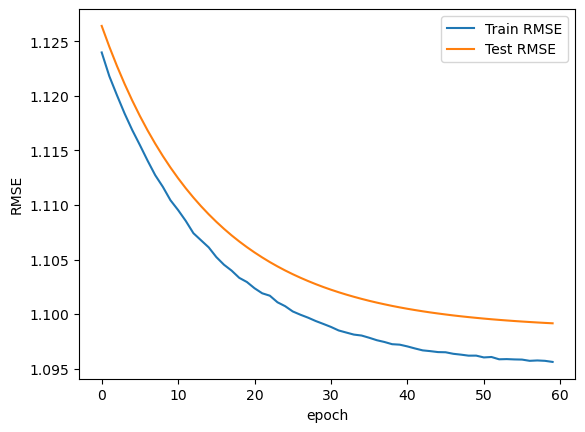

In [9]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [11]:
# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print('Actuals : \n', ratings_test[0:6])
print()
print('Predictions : \n', predictions)

1/1 [==============================] - 0s 25ms/step
Actuals : 
        user_id  movie_id  rating
82365      933       176       3
53333      648        17       2
8144        70       472       3
71653      796      1303       2
86579      708       225       2
34485      392       173       4

Predictions : 
 [[3.5113113]
 [3.4877787]
 [3.4967175]
 [3.5339153]
 [3.484677 ]
 [3.6283557]]


In [22]:
# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order = 'C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

782/782 [==============================] - 1s 1ms/step


1.1000123266395634

### 7.3 딥러닝을 적용한 추천 시스템

In [26]:
# Variable 초기화
K = 200 # Latent factor 수
mu = ratings_train.rating.mean()    # 전체 평균
M = ratings.user_id.max() + 1   # number of users
N = ratings.movie_id.max() + 1  # number of movies

# Keras model
user = Input(shape = (1,))  # User input
item = Input(shape = (1,))  # Item input
P_embedding = Embedding(M, K, embeddings_regularizer = l2())(user)  # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer = l2())(item)  # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user) # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item) # Item bias term (N, 1, )

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)    # (K, )
Q_embedding = Flatten()(Q_embedding)    # (K, )
user_bias = Flatten()(user_bias)    # (1, )
item_bias = Flatten()(item_bias)    # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias]) # (2K + 2, )

In [27]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs = [user, item], outputs = R)
model.compile(
    loss = RMSE,
    optimizer = SGD(), # Adamax()
    metrics = [RMSE]
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 1, 200)               188800    ['input_10[0][0]']            
                                                                                                  
 embedding_14 (Embedding)    (None, 1, 200)               336600    ['input_11[0][0]']            
                                                                                            

                                                                                                  
 flatten_6 (Flatten)         (None, 200)                  0         ['embedding_13[0][0]']        
                                                                                                  
 flatten_7 (Flatten)         (None, 200)                  0         ['embedding_14[0][0]']        
                                                                                                  
 flatten_8 (Flatten)         (None, 1)                    0         ['embedding_15[0][0]']        
                                                                                                  
 flatten_9 (Flatten)         (None, 1)                    0         ['embedding_16[0][0]']        
                                                                                                  
 concatenate_1 (Concatenate  (None, 402)                  0         ['flatten_6[0][0]',           
 )        

In [28]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

Epoch 1/65
147/147 [==============================] - 4s 25ms/step - loss: 5.3899 - RMSE: 1.1245 - val_loss: 5.2671 - val_RMSE: 1.1272
Epoch 2/65
147/147 [==============================] - 4s 24ms/step - loss: 5.1455 - RMSE: 1.1236 - val_loss: 5.0299 - val_RMSE: 1.1264
Epoch 3/65
147/147 [==============================] - 3s 23ms/step - loss: 4.9150 - RMSE: 1.1225 - val_loss: 4.8062 - val_RMSE: 1.1256
Epoch 4/65
147/147 [==============================] - 3s 22ms/step - loss: 4.6976 - RMSE: 1.1219 - val_loss: 4.5953 - val_RMSE: 1.1249
Epoch 5/65
147/147 [==============================] - 3s 22ms/step - loss: 4.4928 - RMSE: 1.1213 - val_loss: 4.3964 - val_RMSE: 1.1241
Epoch 6/65
147/147 [==============================] - 3s 22ms/step - loss: 4.2995 - RMSE: 1.1204 - val_loss: 4.2089 - val_RMSE: 1.1235
Epoch 7/65
147/147 [==============================] - 3s 22ms/step - loss: 4.1173 - RMSE: 1.1196 - val_loss: 4.0318 - val_RMSE: 1.1226
Epoch 8/65
147/147 [==============================] - 3

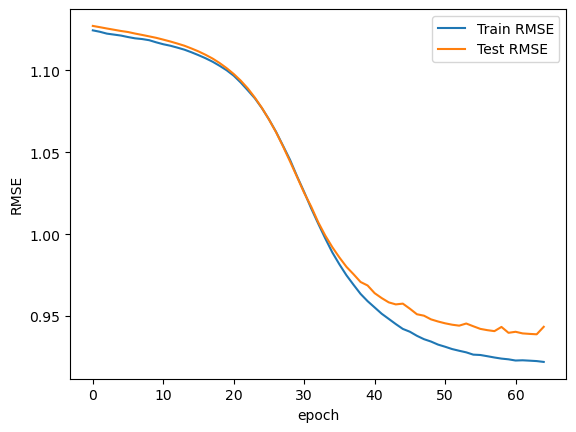

In [29]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = "Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [30]:
# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

1/1 [==============================] - 0s 80ms/step
Actuals: 
        user_id  movie_id  rating
82365      933       176       3
53333      648        17       2
8144        70       472       3
71653      796      1303       2
86579      708       225       2
34485      392       173       4

Predictions: 
 [[3.0137322]
 [2.9952934]
 [2.8451087]
 [2.768748 ]
 [2.7437837]
 [4.269826 ]]


In [31]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

782/782 [==============================] - 2s 3ms/step


0.9439129247995828

### 7.4 딥러닝 모델에 변수 추가하기

지금까지의 딥러닝 모델은 아이템의 평점만 사용하였는데 딥러닝 신경망은 필요하면 다양한 변수를 추가할 수 있다.  
여기서는 직업을 추가로 사용하기로 한다.

In [39]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/u.user', sep = '|', names = u_cols)
users = users[['user_id', 'occupation']]

# Convert occupation(string to integer)
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]
users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation)
train_occ = pd.merge(ratings_train, users, on = 'user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on = 'user_id')['occupation']

In [40]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

##### (2)

# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

In [41]:
occ = Input(shape = (1, ))
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
occ_layer = Flatten()(occ_embedding)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])

In [42]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

In [43]:
model = Model(inputs = [user, item, occ], outputs = R)
model.compile(
    loss = RMSE,
    optimizer = SGD(), # Adamax()
    metrics = [RMSE]
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_17 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_25 (Embedding)    (None, 1, 200)               188800    ['input_16[0][0]']            
                                                                                            

In [44]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],
    ratings_test.rating.values - mu
  )
)

Epoch 1/65
147/147 [==============================] - 5s 26ms/step - loss: 5.4046 - RMSE: 1.1240 - val_loss: 5.2816 - val_RMSE: 1.1271
Epoch 2/65
147/147 [==============================] - 4s 26ms/step - loss: 5.1592 - RMSE: 1.1237 - val_loss: 5.0436 - val_RMSE: 1.1264
Epoch 3/65
147/147 [==============================] - 4s 26ms/step - loss: 4.9280 - RMSE: 1.1222 - val_loss: 4.8191 - val_RMSE: 1.1256
Epoch 4/65
147/147 [==============================] - 3s 23ms/step - loss: 4.7099 - RMSE: 1.1212 - val_loss: 4.6074 - val_RMSE: 1.1248
Epoch 5/65
147/147 [==============================] - 3s 22ms/step - loss: 4.5042 - RMSE: 1.1208 - val_loss: 4.4079 - val_RMSE: 1.1241
Epoch 6/65
147/147 [==============================] - 3s 22ms/step - loss: 4.3103 - RMSE: 1.1200 - val_loss: 4.2196 - val_RMSE: 1.1233
Epoch 7/65
147/147 [==============================] - 3s 22ms/step - loss: 4.1275 - RMSE: 1.1195 - val_loss: 4.0421 - val_RMSE: 1.1225
Epoch 8/65
147/147 [==============================] - 3

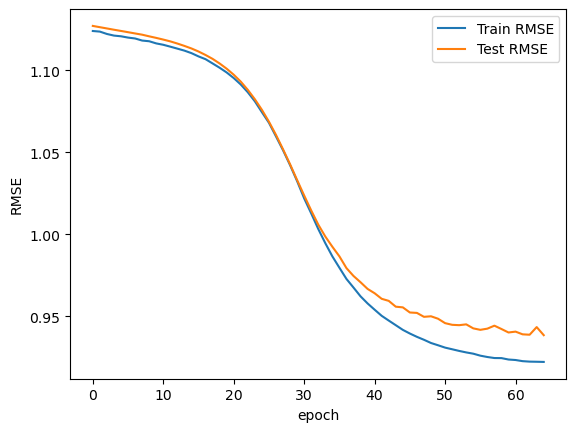

In [45]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [46]:
# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
user_occ = test_occ[0:6]
predictions = model.predict([user_ids, movie_ids, user_occ]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

1/1 [==============================] - 0s 104ms/step
Actuals: 
        user_id  movie_id  rating
82365      933       176       3
53333      648        17       2
8144        70       472       3
71653      796      1303       2
86579      708       225       2
34485      392       173       4

Predictions: 
 [[3.1017382]
 [3.075525 ]
 [2.9590085]
 [2.8919256]
 [2.8673031]
 [4.4219213]]


In [47]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids, test_occ]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

782/782 [==============================] - 2s 2ms/step


0.9388898937832153